In [1]:
"""
VAE Implementation for CelebA Dataset - Portfolio 3 Phase 1
Baseline model with latent_dim = 256

Team Members: Harsha Sathish, Riya Biju, Harshith Babu Prakash Babu
Date: December 2025
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ============================================================================
# Dataset Class
# ============================================================================

class CelebADataset(Dataset):
    """
    Custom Dataset for CelebA aligned and cropped images
    """
    def __init__(self, root_dir, partition_file, split='train', transform=None, subset_size=None):
        """
        Args:
            root_dir: Path to CelebA directory
            partition_file: Path to list_eval_partition.txt
            split: 'train', 'val', or 'test' (0, 1, 2 in partition file)
            transform: Transformations to apply
            subset_size: If specified, use only this many images (for faster training)
        """
        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'Img', 'img_align_celeba')
        self.transform = transform
        
        # Load partition information
        self.image_files = []
        split_map = {'train': 0, 'val': 1, 'test': 2}
        split_id = split_map[split]
        
        with open(partition_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 2:
                    img_name, partition = parts
                    if int(partition) == split_id:
                        self.image_files.append(img_name)
        
        # Apply subset if specified
        if subset_size is not None and subset_size < len(self.image_files):
            np.random.seed(42)
            indices = np.random.choice(len(self.image_files), subset_size, replace=False)
            self.image_files = [self.image_files[i] for i in sorted(indices)]
        
        print(f"{split.upper()} set: {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


# ============================================================================
# VAE Model Architecture
# ============================================================================

class VAE(nn.Module):
    """
    Convolutional Variational Autoencoder for CelebA (64x64 images)
    """
    def __init__(self, latent_dim=256, img_channels=3):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # ====== ENCODER ======
        # Input: (3, 64, 64)
        self.encoder = nn.Sequential(
            # Layer 1: (3, 64, 64) -> (32, 32, 32)
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: (32, 32, 32) -> (64, 16, 16)
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: (64, 16, 16) -> (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4: (128, 8, 8) -> (256, 4, 4)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # Flattened feature size: 256 * 4 * 4 = 4096
        self.fc_encoder = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True)
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # ====== DECODER ======
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256 * 4 * 4),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: Mirror of encoder
        self.decoder = nn.Sequential(
            # Layer 1: (256, 4, 4) -> (128, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Layer 2: (128, 8, 8) -> (64, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Layer 3: (64, 16, 16) -> (32, 32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Layer 4: (32, 32, 32) -> (3, 64, 64)
            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten
        h = self.fc_encoder(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vector to image"""
        h = self.fc_decoder(z)
        h = h.view(h.size(0), 256, 4, 4)  # Reshape
        return self.decoder(h)
    
    def forward(self, x):
        """Full forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# ============================================================================
# Loss Function - CORRECTED VERSION
# ============================================================================
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE Loss - Production Ready Version
    """
    batch_size = x.size(0)
    
    # Reconstruction: Binary cross-entropy
    # Sum over pixels, mean over batch
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_size
    # Per-pixel for display
    recon_loss_display = recon_loss / (x.size(1) * x.size(2) * x.size(3))
    
    # KL Divergence
    # Sum over latent dims, mean over batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    
    # Total (both terms are now comparable in magnitude)
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss_display, kl_loss



# ============================================================================
# Training Function - WITH SAFETY CHECKS
# ============================================================================

def train_epoch(model, train_loader, optimizer, epoch, beta=1.0):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, data in enumerate(pbar):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # SAFETY CHECK: Detect posterior collapse
        if kl_loss.item() < 1.0 and epoch > 1:
            print(f"\n⚠️ WARNING: KL collapsed at epoch {epoch}, batch {batch_idx}")
            print(f"   KL: {kl_loss.item():.6f}")
            print(f"   mu range: [{mu.min():.4f}, {mu.max():.4f}]")
            print(f"   logvar range: [{logvar.min():.4f}, {logvar.max():.4f}]")
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate losses
        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}'
        })
    
    # Average losses
    n_batches = len(train_loader)
    return train_loss / n_batches, train_recon_loss / n_batches, train_kl_loss / n_batches


def validate(model, val_loader, beta=1.0):
    """Validate the model"""
    model.eval()
    val_loss = 0
    val_recon_loss = 0
    val_kl_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()
    
    # Average losses
    n_batches = len(val_loader)
    return val_loss / n_batches, val_recon_loss / n_batches, val_kl_loss / n_batches


# ============================================================================
# Visualization Functions
# ============================================================================

def save_sample_images(model, val_loader, epoch, save_dir, num_samples=8):
    """Save sample reconstructions"""
    model.eval()
    
    # Get a batch
    data = next(iter(val_loader))[:num_samples].to(device)
    
    with torch.no_grad():
        recon, _, _ = model(data)
    
    # Move to CPU and denormalize
    data = data.cpu()
    recon = recon.cpu()
    
    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    for i in range(num_samples):
        # Original
        axes[0, i].imshow(data[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(recon[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'reconstruction_epoch_{epoch}.png'), dpi=100, bbox_inches='tight')
    plt.close()


def plot_training_curves(history, save_dir):
    """Plot and save training curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Total Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Total Loss')
    axes[0].set_title('Total Loss (ELBO)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[1].plot(epochs, history['train_recon'], label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_recon'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Reconstruction Loss')
    axes[1].set_title('Reconstruction Loss (BCE)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # KL Divergence
    axes[2].plot(epochs, history['train_kl'], label='Train', linewidth=2)
    axes[2].plot(epochs, history['val_kl'], label='Validation', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('KL Divergence')
    axes[2].set_title('KL Divergence')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()


# ============================================================================
# Main Training Script
# ============================================================================

def main():
    # ========== Configuration ==========
    config = {
        'latent_dim': 256,
        'beta': 1.0,  # Standard VAE (β-VAE will use different values)
        'img_size': 64,
        'batch_size': 128,
        'num_epochs': 50,
        'learning_rate': 1e-3,
        'subset_train': 50000,  # Use 50k training images (adjust as needed)
        'subset_val': 5000,     # Use 5k validation images
        'num_workers': 0,       # DataLoader workers
        'save_interval': 5,     # Save checkpoint every N epochs
    }
    
    print("=" * 60)
    print("VAE Training Configuration")
    print("=" * 60)
    for key, value in config.items():
        print(f"{key:20s}: {value}")
    print("=" * 60)
    
    # ========== Paths ==========
    celeba_root = './CelebA'  # Adjust if needed
    partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')
    
    # Create output directories
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./outputs/vae_baseline_latent{config["latent_dim"]}_{timestamp}'
    checkpoint_dir = os.path.join(output_dir, 'checkpoints')
    sample_dir = os.path.join(output_dir, 'samples')
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(sample_dir, exist_ok=True)
    
    # Save configuration
    with open(os.path.join(output_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    # ========== Data Transforms ==========
    transform = transforms.Compose([
        transforms.Resize(config['img_size']),
        transforms.CenterCrop(config['img_size']),
        transforms.ToTensor(),
        # Images are already in [0, 1] after ToTensor()
    ])
    
    # ========== Datasets and DataLoaders ==========
    print("\nLoading datasets...")
    train_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='train',
        transform=transform,
        subset_size=config['subset_train']
    )
    
    val_dataset = CelebADataset(
        root_dir=celeba_root,
        partition_file=partition_file,
        split='val',
        transform=transform,
        subset_size=config['subset_val']
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    # ========== Model Setup ==========
    print("\nInitializing model...")
    model = VAE(latent_dim=config['latent_dim']).to(device)
    
    # Print model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # ========== Training Loop ==========
    print("\n" + "=" * 60)
    print("Starting Training")
    print("=" * 60)
    
    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'val_loss': [], 'val_recon': [], 'val_kl': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(1, config['num_epochs'] + 1):
        # Train
        train_loss, train_recon, train_kl = train_epoch(
            model, train_loader, optimizer, epoch, beta=config['beta']
        )
        
        # Validate
        val_loss, val_recon, val_kl = validate(model, val_loader, beta=config['beta'])
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_recon'].append(train_recon)
        history['train_kl'].append(train_kl)
        history['val_loss'].append(val_loss)
        history['val_recon'].append(val_recon)
        history['val_kl'].append(val_kl)
        
        # Print epoch summary
        print(f"\nEpoch {epoch}/{config['num_epochs']}:")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")
        
        # HEALTH CHECK
        if val_kl < 10.0:
            print(f"  ⚠️  WARNING: KL very low ({val_kl:.4f}) - monitor for collapse")
        elif val_kl > 200.0:
            print(f"  ⚠️  WARNING: KL very high ({val_kl:.4f}) - model may ignore inputs")
        
        # Save sample reconstructions
        if epoch % config['save_interval'] == 0:
            save_sample_images(model, val_loader, epoch, sample_dir)
        
        # Save checkpoint
        if epoch % config['save_interval'] == 0 or epoch == config['num_epochs']:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
            }
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(checkpoint, checkpoint_path)
            print(f"  Saved checkpoint: {checkpoint_path}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': config,
                'history': history,
                'val_loss': val_loss,
            }
            best_path = os.path.join(checkpoint_dir, 'best_model.pth')
            torch.save(best_checkpoint, best_path)
            print(f"  ⭐ New best model saved! Val Loss: {val_loss:.4f}")
    
    # ========== Final Steps ==========
    print("\n" + "=" * 60)
    print("Training Complete!")
    print("=" * 60)
    
    # Plot training curves
    plot_training_curves(history, output_dir)
    print(f"\nTraining curves saved to: {output_dir}/training_curves.png")
    
    # Save final model
    final_checkpoint = {
        'epoch': config['num_epochs'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'config': config,
        'history': history,
    }
    final_path = os.path.join(checkpoint_dir, 'final_model.pth')
    torch.save(final_checkpoint, final_path)
    print(f"Final model saved to: {final_path}")
    
    # Save training history
    with open(os.path.join(output_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f, indent=4)
    
    print(f"\nAll outputs saved to: {output_dir}")
    print(f"Best validation loss: {best_val_loss:.4f}")


if __name__ == '__main__':
    main()

Using device: cpu
VAE Training Configuration
latent_dim          : 256
beta                : 1.0
img_size            : 64
batch_size          : 128
num_epochs          : 50
learning_rate       : 0.001
subset_train        : 50000
subset_val          : 5000
num_workers         : 0
save_interval       : 5

Loading datasets...
TRAIN set: 50000 images
VAL set: 5000 images

Initializing model...
Total parameters: 5,974,595
Trainable parameters: 5,974,595

Starting Training


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]/Users/harshasathish/Desktop/MAI/ComputerVision/Portfolio3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/harshasathish/Desktop/MAI/ComputerVision/Portfolio3/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s, Loss=6559.2979, Recon=0.5279, KL=72.1932]



Epoch 1/50:
  Train - Loss: 6948.8199, Recon: 0.5599, KL: 68.2523
  Val   - Loss: 6702.3334, Recon: 0.5392, KL: 77.1807
  ⭐ New best model saved! Val Loss: 6702.3334


Epoch 2: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s, Loss=6624.1577, Recon=0.5324, KL=82.4337]



Epoch 2/50:
  Train - Loss: 6614.5596, Recon: 0.5319, KL: 78.8983
  Val   - Loss: 6569.9436, Recon: 0.5279, KL: 83.1417
  ⭐ New best model saved! Val Loss: 6569.9436


Epoch 3: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6331.2393, Recon=0.5090, KL=76.5131]



Epoch 3/50:
  Train - Loss: 6521.0457, Recon: 0.5243, KL: 78.4101
  Val   - Loss: 6507.4066, Recon: 0.5232, KL: 78.1029
  ⭐ New best model saved! Val Loss: 6507.4066


Epoch 4: 100%|██████████| 391/391 [02:09<00:00,  3.02it/s, Loss=6720.4414, Recon=0.5406, KL=77.5282]



Epoch 4/50:
  Train - Loss: 6474.1872, Recon: 0.5206, KL: 77.3208
  Val   - Loss: 6466.3279, Recon: 0.5201, KL: 75.5083
  ⭐ New best model saved! Val Loss: 6466.3279


Epoch 5: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=6419.3618, Recon=0.5163, KL=75.0206]



Epoch 5/50:
  Train - Loss: 6446.6141, Recon: 0.5185, KL: 75.3636
  Val   - Loss: 6447.3422, Recon: 0.5187, KL: 73.9579
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_5.pth
  ⭐ New best model saved! Val Loss: 6447.3422
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_5.pth
  ⭐ New best model saved! Val Loss: 6447.3422


Epoch 6: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s, Loss=6281.4463, Recon=0.5052, KL=73.3085]



Epoch 6/50:
  Train - Loss: 6427.6480, Recon: 0.5170, KL: 74.7892
  Val   - Loss: 6430.3993, Recon: 0.5172, KL: 75.3400
  ⭐ New best model saved! Val Loss: 6430.3993


Epoch 7: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=6362.2764, Recon=0.5116, KL=75.4692]



Epoch 7/50:
  Train - Loss: 6413.4074, Recon: 0.5158, KL: 74.7662
  Val   - Loss: 6438.8039, Recon: 0.5179, KL: 74.4325


Epoch 8: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s, Loss=6276.8101, Recon=0.5048, KL=73.2933]




Epoch 8/50:
  Train - Loss: 6401.8205, Recon: 0.5149, KL: 74.7419
  Val   - Loss: 6413.5247, Recon: 0.5158, KL: 75.3418
  ⭐ New best model saved! Val Loss: 6413.5247


Epoch 9: 100%|██████████| 391/391 [02:04<00:00,  3.14it/s, Loss=6695.3223, Recon=0.5386, KL=77.6101]



Epoch 9/50:
  Train - Loss: 6395.3357, Recon: 0.5144, KL: 74.9071
  Val   - Loss: 6410.5635, Recon: 0.5156, KL: 75.0131
  ⭐ New best model saved! Val Loss: 6410.5635


Epoch 10: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s, Loss=6469.0264, Recon=0.5204, KL=74.8580]



Epoch 10/50:
  Train - Loss: 6389.8616, Recon: 0.5139, KL: 75.4880
  Val   - Loss: 6401.9117, Recon: 0.5149, KL: 75.1524
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_10.pth
  ⭐ New best model saved! Val Loss: 6401.9117
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_10.pth
  ⭐ New best model saved! Val Loss: 6401.9117


Epoch 11: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s, Loss=6421.5029, Recon=0.5161, KL=79.1364]



Epoch 11/50:
  Train - Loss: 6383.3839, Recon: 0.5133, KL: 75.6574
  Val   - Loss: 6402.5853, Recon: 0.5150, KL: 74.3273


Epoch 12: 100%|██████████| 391/391 [02:02<00:00,  3.18it/s, Loss=6381.7974, Recon=0.5130, KL=77.6782]



Epoch 12/50:
  Train - Loss: 6378.6005, Recon: 0.5129, KL: 75.7943
  Val   - Loss: 6395.3476, Recon: 0.5143, KL: 75.7102
  ⭐ New best model saved! Val Loss: 6395.3476


Epoch 13: 100%|██████████| 391/391 [02:10<00:00,  2.99it/s, Loss=6338.5859, Recon=0.5096, KL=76.3688]




Epoch 13/50:
  Train - Loss: 6375.3947, Recon: 0.5126, KL: 76.4951
  Val   - Loss: 6421.8035, Recon: 0.5166, KL: 74.3666


Epoch 14: 100%|██████████| 391/391 [02:07<00:00,  3.08it/s, Loss=6403.8433, Recon=0.5149, KL=76.6488]



Epoch 14/50:
  Train - Loss: 6371.5492, Recon: 0.5123, KL: 77.0152
  Val   - Loss: 6388.4294, Recon: 0.5137, KL: 76.1805
  ⭐ New best model saved! Val Loss: 6388.4294


Epoch 15: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=6506.9072, Recon=0.5231, KL=78.7087]



Epoch 15/50:
  Train - Loss: 6367.4828, Recon: 0.5119, KL: 77.3354
  Val   - Loss: 6385.1714, Recon: 0.5134, KL: 76.5772
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_15.pth
  ⭐ New best model saved! Val Loss: 6385.1714
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_15.pth
  ⭐ New best model saved! Val Loss: 6385.1714


Epoch 16: 100%|██████████| 391/391 [02:08<00:00,  3.05it/s, Loss=6523.4390, Recon=0.5244, KL=80.2115]



Epoch 16/50:
  Train - Loss: 6365.7464, Recon: 0.5117, KL: 77.6112
  Val   - Loss: 6387.4278, Recon: 0.5135, KL: 77.7312


Epoch 17: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6257.0332, Recon=0.5030, KL=76.2648]



Epoch 17/50:
  Train - Loss: 6362.0825, Recon: 0.5114, KL: 77.7354
  Val   - Loss: 6382.2275, Recon: 0.5131, KL: 77.3901
  ⭐ New best model saved! Val Loss: 6382.2275


Epoch 18: 100%|██████████| 391/391 [02:03<00:00,  3.17it/s, Loss=6352.6973, Recon=0.5105, KL=79.1191]



Epoch 18/50:
  Train - Loss: 6358.5764, Recon: 0.5111, KL: 78.1409
  Val   - Loss: 6380.7965, Recon: 0.5128, KL: 79.9602
  ⭐ New best model saved! Val Loss: 6380.7965


Epoch 19: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6318.0029, Recon=0.5074, KL=82.7585]



Epoch 19/50:
  Train - Loss: 6356.7127, Recon: 0.5109, KL: 78.4851
  Val   - Loss: 6394.6918, Recon: 0.5138, KL: 81.7094


Epoch 20: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=6538.7363, Recon=0.5256, KL=79.6861]



Epoch 20/50:
  Train - Loss: 6355.1869, Recon: 0.5108, KL: 78.6458
  Val   - Loss: 6390.1313, Recon: 0.5136, KL: 78.6208
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_20.pth
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_20.pth


Epoch 21: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=6506.5947, Recon=0.5232, KL=77.7293]



Epoch 21/50:
  Train - Loss: 6352.7552, Recon: 0.5106, KL: 78.7659
  Val   - Loss: 6377.1994, Recon: 0.5125, KL: 79.3785
  ⭐ New best model saved! Val Loss: 6377.1994


Epoch 22: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6249.5142, Recon=0.5021, KL=79.1616]



Epoch 22/50:
  Train - Loss: 6350.8356, Recon: 0.5104, KL: 78.9586
  Val   - Loss: 6377.7741, Recon: 0.5127, KL: 77.7097


Epoch 23: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s, Loss=6230.3267, Recon=0.5005, KL=80.5054]




Epoch 23/50:
  Train - Loss: 6349.6626, Recon: 0.5103, KL: 79.2648
  Val   - Loss: 6371.3410, Recon: 0.5121, KL: 79.2221
  ⭐ New best model saved! Val Loss: 6371.3410


Epoch 24: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6493.5454, Recon=0.5221, KL=77.6517]




Epoch 24/50:
  Train - Loss: 6347.6257, Recon: 0.5101, KL: 79.3859
  Val   - Loss: 6376.3538, Recon: 0.5125, KL: 79.1903


Epoch 25: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6370.1250, Recon=0.5115, KL=84.5861]




Epoch 25/50:
  Train - Loss: 6345.4119, Recon: 0.5099, KL: 79.5983
  Val   - Loss: 6373.6888, Recon: 0.5121, KL: 81.0137
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_25.pth
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_25.pth


Epoch 26: 100%|██████████| 391/391 [02:09<00:00,  3.02it/s, Loss=6172.4165, Recon=0.4958, KL=79.6923]



Epoch 26/50:
  Train - Loss: 6344.2054, Recon: 0.5098, KL: 79.8311
  Val   - Loss: 6373.3708, Recon: 0.5122, KL: 79.2313


Epoch 27: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s, Loss=6495.1138, Recon=0.5220, KL=80.3313]



Epoch 27/50:
  Train - Loss: 6343.1766, Recon: 0.5097, KL: 80.0794
  Val   - Loss: 6370.4731, Recon: 0.5120, KL: 79.3608
  ⭐ New best model saved! Val Loss: 6370.4731


Epoch 28: 100%|██████████| 391/391 [02:05<00:00,  3.11it/s, Loss=6207.2544, Recon=0.4988, KL=77.6133]




Epoch 28/50:
  Train - Loss: 6341.8301, Recon: 0.5096, KL: 80.1992
  Val   - Loss: 6381.2100, Recon: 0.5128, KL: 80.1745


Epoch 29: 100%|██████████| 391/391 [02:11<00:00,  2.97it/s, Loss=6418.2920, Recon=0.5156, KL=82.0552]



Epoch 29/50:
  Train - Loss: 6342.1280, Recon: 0.5096, KL: 80.3399
  Val   - Loss: 6369.7931, Recon: 0.5118, KL: 80.1908
  ⭐ New best model saved! Val Loss: 6369.7931


Epoch 30: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s, Loss=6385.2603, Recon=0.5130, KL=81.5217]



Epoch 30/50:
  Train - Loss: 6338.8786, Recon: 0.5093, KL: 80.4313
  Val   - Loss: 6364.4694, Recon: 0.5114, KL: 80.2279
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_30.pth
  ⭐ New best model saved! Val Loss: 6364.4694
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_30.pth
  ⭐ New best model saved! Val Loss: 6364.4694


Epoch 31: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s, Loss=6296.3662, Recon=0.5057, KL=82.0754]



Epoch 31/50:
  Train - Loss: 6337.2781, Recon: 0.5092, KL: 80.5440
  Val   - Loss: 6369.6122, Recon: 0.5117, KL: 81.2908


Epoch 32: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6405.1421, Recon=0.5144, KL=84.3702]



Epoch 32/50:
  Train - Loss: 6336.1642, Recon: 0.5091, KL: 80.7220
  Val   - Loss: 6364.6877, Recon: 0.5113, KL: 81.5766


Epoch 33: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6183.8252, Recon=0.4967, KL=80.2834]



Epoch 33/50:
  Train - Loss: 6335.1051, Recon: 0.5090, KL: 80.8415
  Val   - Loss: 6367.2477, Recon: 0.5116, KL: 80.1288


Epoch 34: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6315.5015, Recon=0.5073, KL=81.9084]



Epoch 34/50:
  Train - Loss: 6332.7483, Recon: 0.5088, KL: 80.9786
  Val   - Loss: 6363.3879, Recon: 0.5112, KL: 81.8789
  ⭐ New best model saved! Val Loss: 6363.3879


Epoch 35: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6409.8032, Recon=0.5150, KL=81.3986]



Epoch 35/50:
  Train - Loss: 6332.1564, Recon: 0.5087, KL: 81.0200
  Val   - Loss: 6362.2148, Recon: 0.5112, KL: 80.3603
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_35.pth
  ⭐ New best model saved! Val Loss: 6362.2148
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_35.pth
  ⭐ New best model saved! Val Loss: 6362.2148


Epoch 36: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6430.9390, Recon=0.5165, KL=83.7839]




Epoch 36/50:
  Train - Loss: 6331.7012, Recon: 0.5087, KL: 81.1234
  Val   - Loss: 6365.8525, Recon: 0.5114, KL: 81.7252


Epoch 37: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6427.9946, Recon=0.5166, KL=79.6352]



Epoch 37/50:
  Train - Loss: 6330.7278, Recon: 0.5086, KL: 81.1978
  Val   - Loss: 6362.6730, Recon: 0.5112, KL: 81.0413


Epoch 38: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6369.8320, Recon=0.5117, KL=81.7343]



Epoch 38/50:
  Train - Loss: 6329.2926, Recon: 0.5085, KL: 81.2892
  Val   - Loss: 6361.6617, Recon: 0.5111, KL: 81.6662
  ⭐ New best model saved! Val Loss: 6361.6617


Epoch 39: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6344.2134, Recon=0.5096, KL=81.7104]



Epoch 39/50:
  Train - Loss: 6328.5236, Recon: 0.5084, KL: 81.3714
  Val   - Loss: 6362.3023, Recon: 0.5111, KL: 81.9384


Epoch 40: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6388.0244, Recon=0.5132, KL=82.1739]



Epoch 40/50:
  Train - Loss: 6327.1648, Recon: 0.5083, KL: 81.5825
  Val   - Loss: 6361.5811, Recon: 0.5112, KL: 80.4970
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_40.pth
  ⭐ New best model saved! Val Loss: 6361.5811
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_40.pth
  ⭐ New best model saved! Val Loss: 6361.5811


Epoch 41: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6138.5620, Recon=0.4928, KL=83.1345]



Epoch 41/50:
  Train - Loss: 6326.5821, Recon: 0.5082, KL: 81.6337
  Val   - Loss: 6360.1504, Recon: 0.5109, KL: 82.3725
  ⭐ New best model saved! Val Loss: 6360.1504


Epoch 42: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6377.0942, Recon=0.5124, KL=80.7944]



Epoch 42/50:
  Train - Loss: 6325.4811, Recon: 0.5081, KL: 81.7953
  Val   - Loss: 6360.0375, Recon: 0.5110, KL: 80.4530
  ⭐ New best model saved! Val Loss: 6360.0375


Epoch 43: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6280.2998, Recon=0.5043, KL=83.3046]



Epoch 43/50:
  Train - Loss: 6324.5870, Recon: 0.5080, KL: 81.8736
  Val   - Loss: 6364.2912, Recon: 0.5113, KL: 81.8856


Epoch 44: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s, Loss=6518.9663, Recon=0.5237, KL=83.3234]



Epoch 44/50:
  Train - Loss: 6323.3038, Recon: 0.5079, KL: 82.1200
  Val   - Loss: 6360.0276, Recon: 0.5109, KL: 82.6347
  ⭐ New best model saved! Val Loss: 6360.0276


Epoch 45: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s, Loss=6364.7773, Recon=0.5114, KL=81.0401]



Epoch 45/50:
  Train - Loss: 6322.2638, Recon: 0.5078, KL: 82.1351
  Val   - Loss: 6358.6679, Recon: 0.5108, KL: 81.9074
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_45.pth
  ⭐ New best model saved! Val Loss: 6358.6679
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_45.pth
  ⭐ New best model saved! Val Loss: 6358.6679


Epoch 46: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s, Loss=6389.3950, Recon=0.5133, KL=81.5525]



Epoch 46/50:
  Train - Loss: 6321.4063, Recon: 0.5077, KL: 82.1914
  Val   - Loss: 6361.2495, Recon: 0.5110, KL: 81.7980


Epoch 47: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s, Loss=6211.9800, Recon=0.4989, KL=80.9956]



Epoch 47/50:
  Train - Loss: 6321.0689, Recon: 0.5077, KL: 82.2762
  Val   - Loss: 6356.6466, Recon: 0.5106, KL: 82.3088
  ⭐ New best model saved! Val Loss: 6356.6466


Epoch 48: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=6269.9053, Recon=0.5035, KL=82.4385]



Epoch 48/50:
  Train - Loss: 6321.0768, Recon: 0.5077, KL: 82.3179
  Val   - Loss: 6363.5333, Recon: 0.5112, KL: 82.2594


Epoch 49: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s, Loss=6318.7158, Recon=0.5076, KL=81.3672]



Epoch 49/50:
  Train - Loss: 6319.9064, Recon: 0.5076, KL: 82.3829
  Val   - Loss: 6362.1372, Recon: 0.5110, KL: 82.6108


Epoch 50: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s, Loss=6307.9351, Recon=0.5066, KL=82.2660]



Epoch 50/50:
  Train - Loss: 6318.4841, Recon: 0.5075, KL: 82.4675
  Val   - Loss: 6358.1444, Recon: 0.5107, KL: 83.2122
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_50.pth

Training Complete!

Training curves saved to: ./outputs/vae_baseline_latent256_20260110_125232/training_curves.png
  Saved checkpoint: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/checkpoint_epoch_50.pth

Training Complete!

Training curves saved to: ./outputs/vae_baseline_latent256_20260110_125232/training_curves.png
Final model saved to: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/final_model.pth

All outputs saved to: ./outputs/vae_baseline_latent256_20260110_125232
Best validation loss: 6356.6466
Final model saved to: ./outputs/vae_baseline_latent256_20260110_125232/checkpoints/final_model.pth

All outputs saved to: ./outputs/vae_baseline_latent256_20260110_125232
Best validation loss: 6356.6466


VAE Model Testing and Visualization

Using output directory: ./outputs_256/vae_baseline_latent256_20260110_125232
Loading BEST model: ./outputs_256/vae_baseline_latent256_20260110_125232/checkpoints/best_model.pth

Loading Trained Model
✅ Model loaded successfully!
   Epoch: 47
   Latent dimension: 256
   Validation loss: 6356.6466

Loading Test Dataset
TEST set: 2000 images
✅ Test dataset loaded: 2000 images

Generating Reconstructions


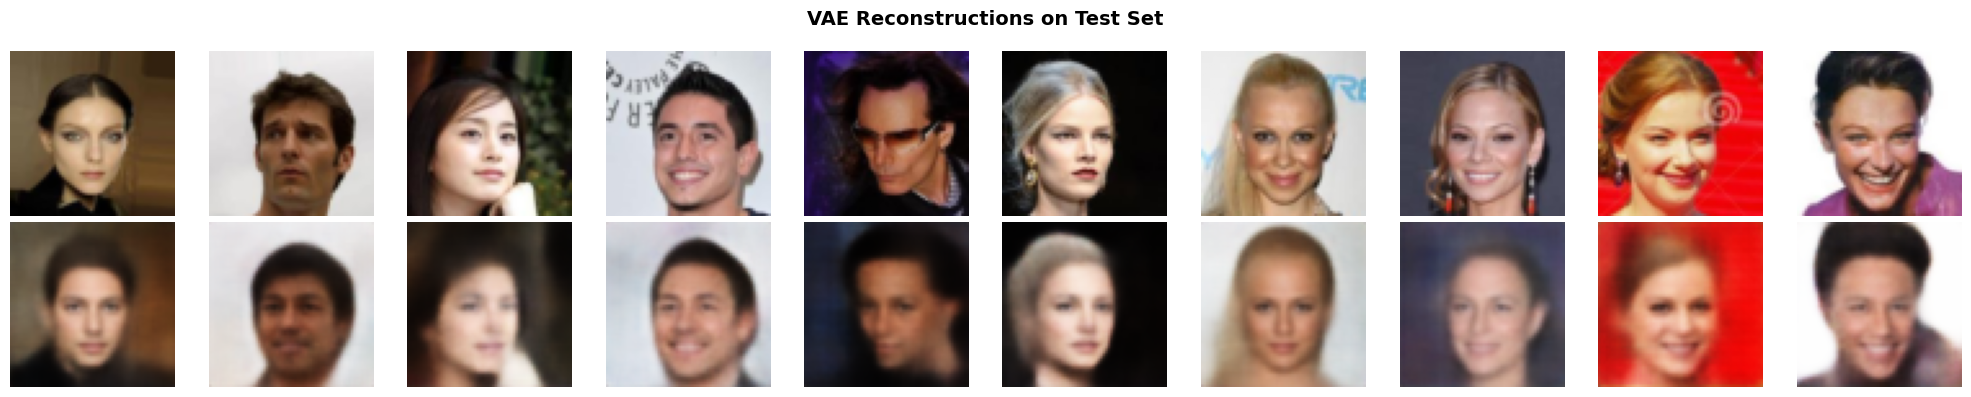

✅ Reconstructions displayed above

Generating Random Samples from Latent Space


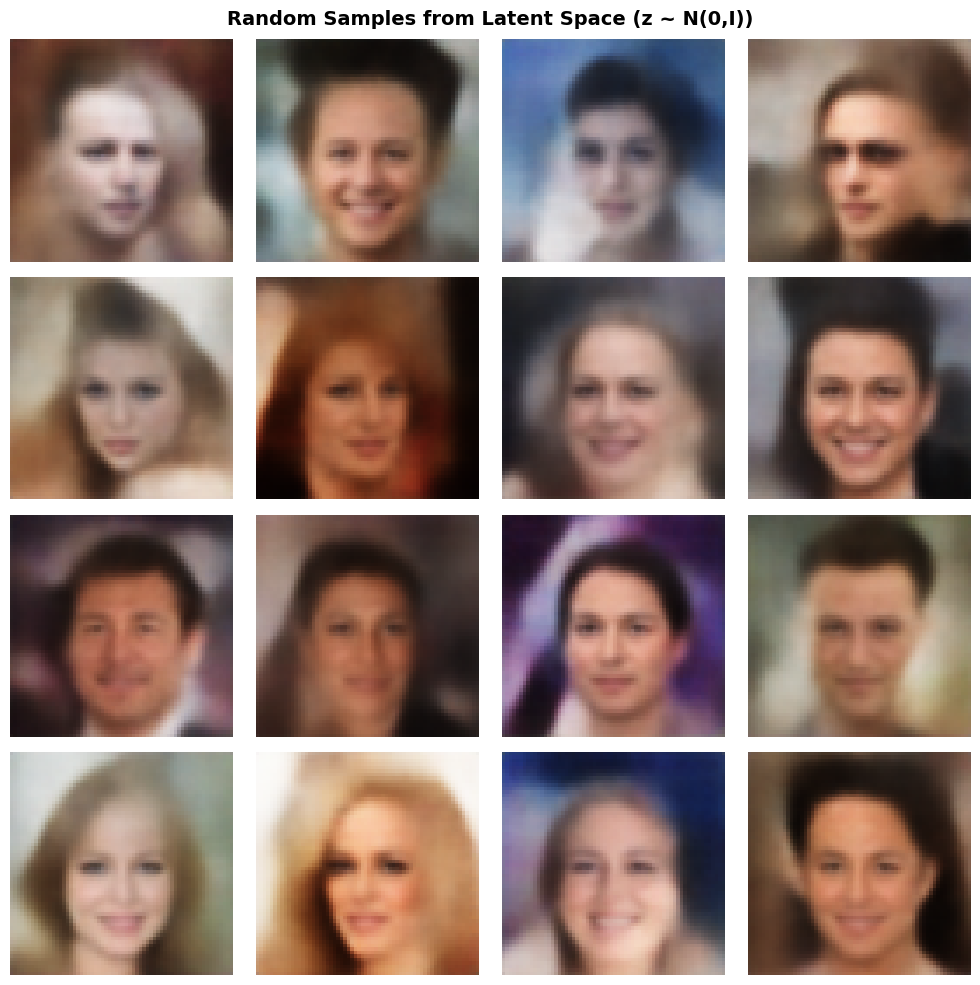

✅ Random samples displayed above

Generating Latent Space Interpolations


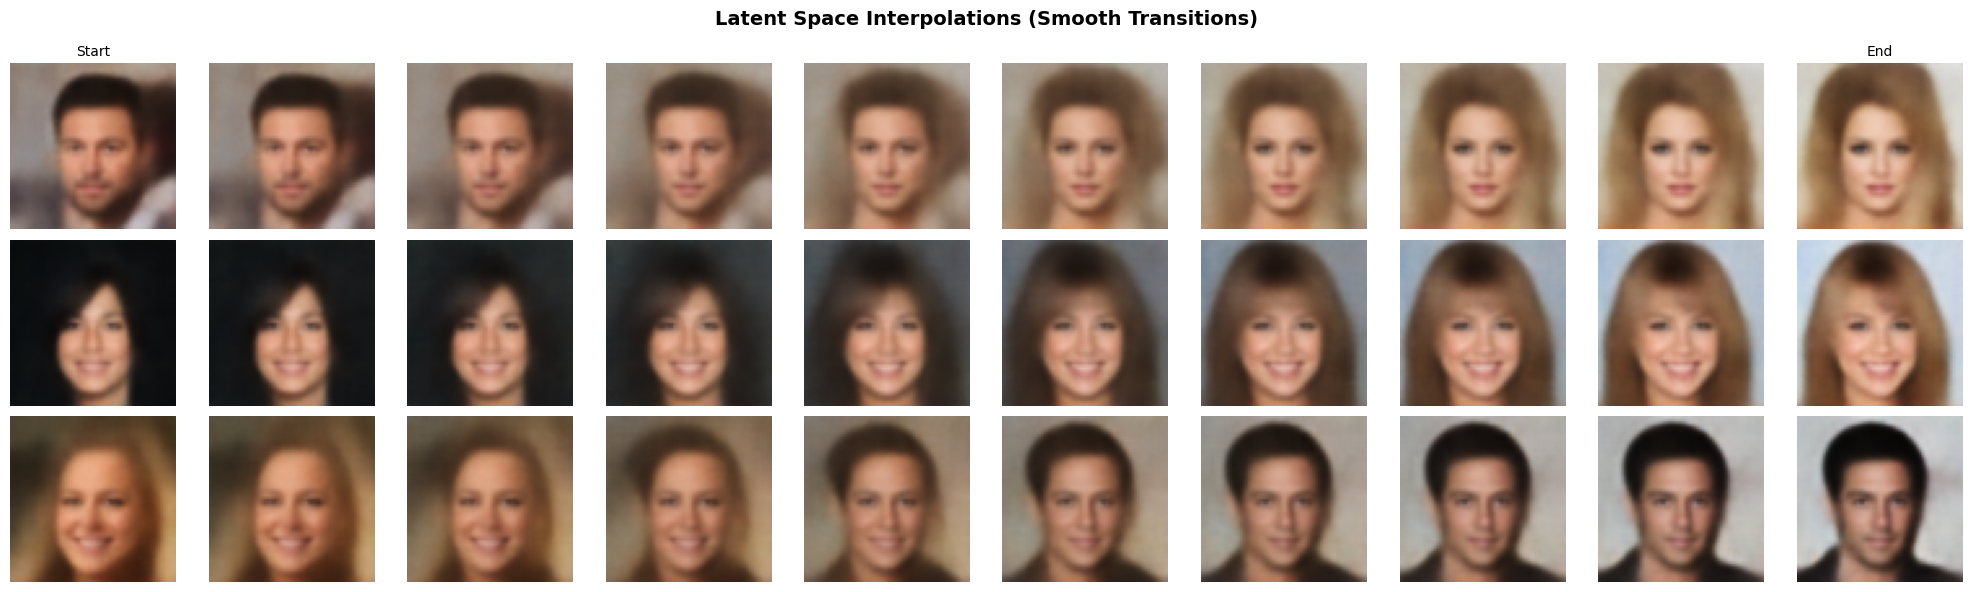

✅ Interpolations displayed above

Generating Latent Dimension Traversals


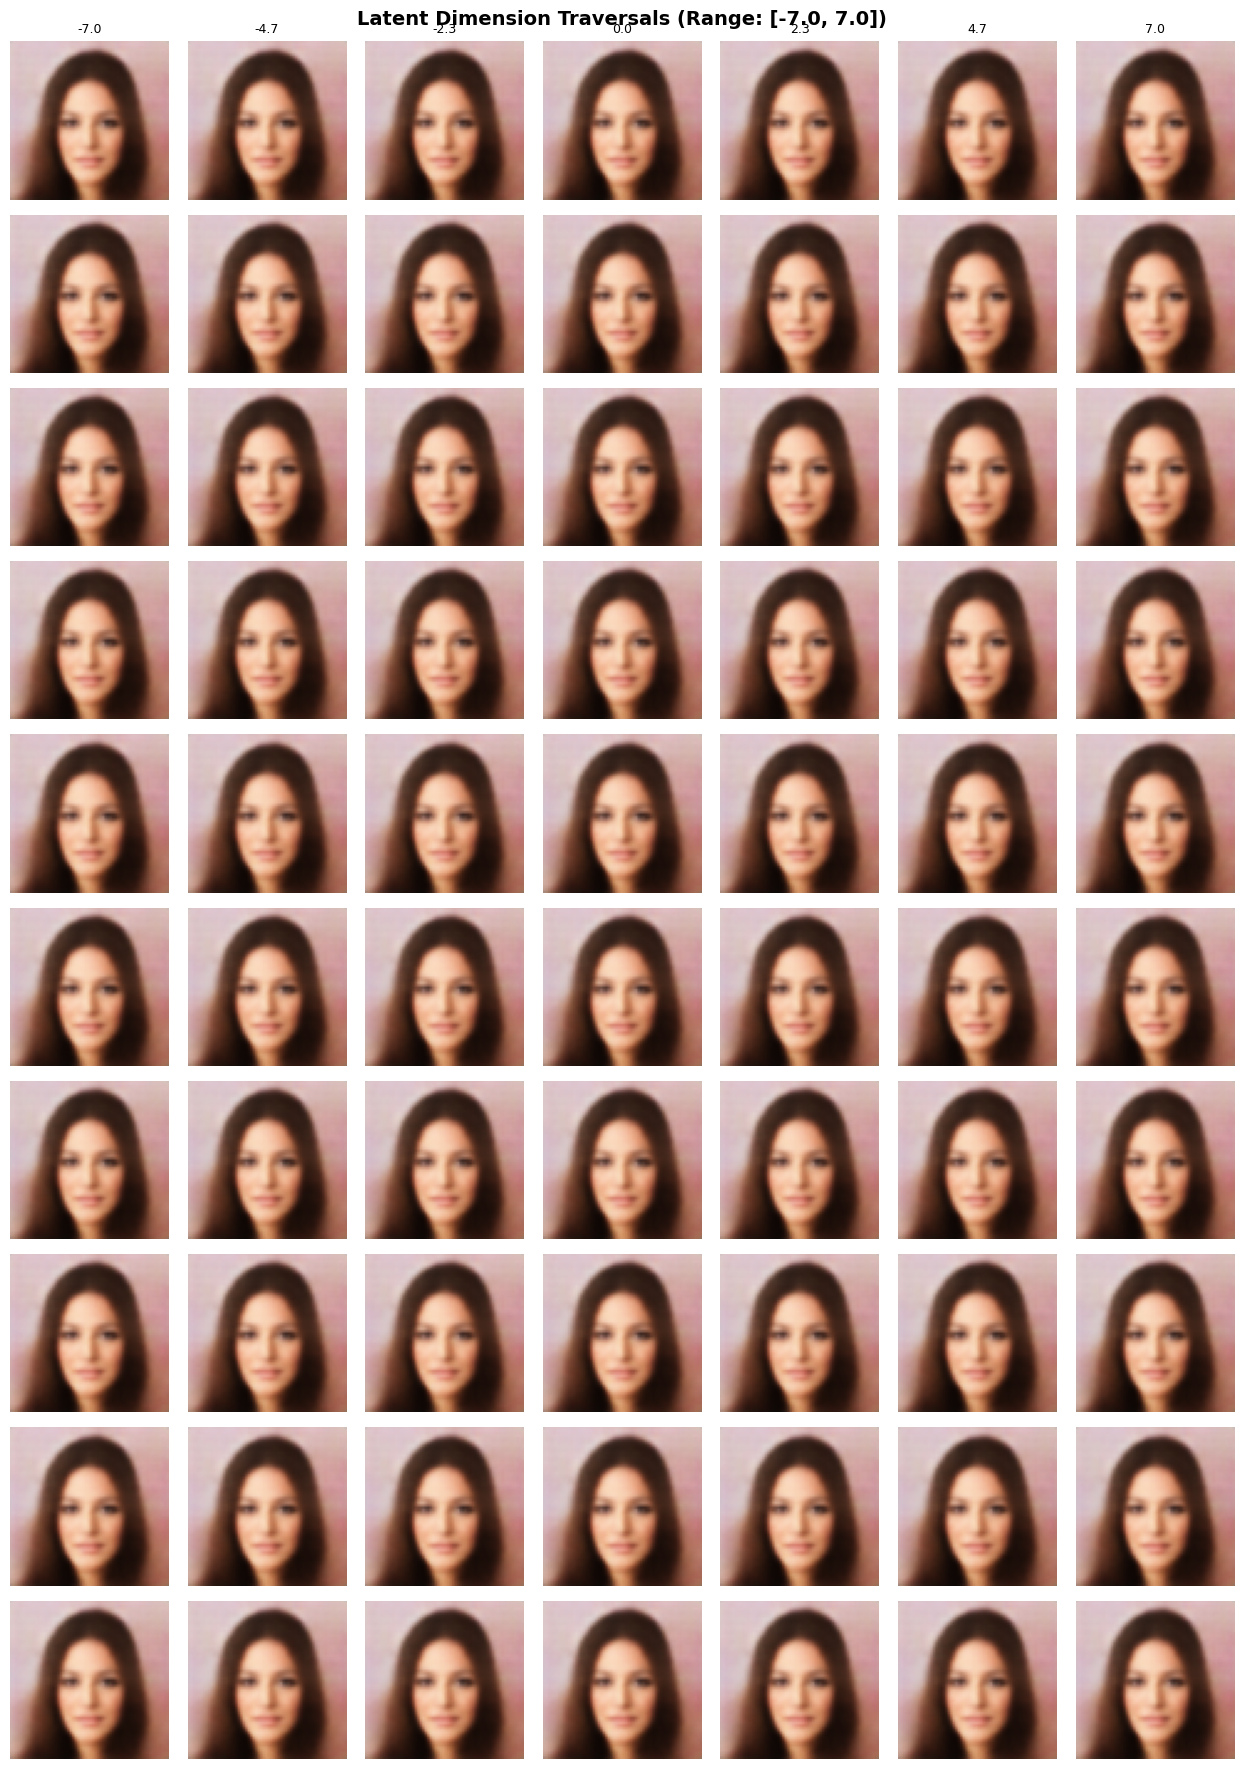

✅ Latent traversals displayed above
   Each row shows how varying a single latent dimension affects the generated face

Computing Reconstruction Quality Metrics
✅ Reconstruction Quality Metrics (on 10 test batches):
   Mean Squared Error (MSE): 0.009046
   Mean Absolute Error (MAE): 0.065171

Testing Complete - Summary

📊 Model Information:
   Latent Dimension: 256
   Image Size: 64×64
   Training Epochs: 47
   Beta (β): 1.0

📈 Performance:
   Best Validation Loss: 6356.6466
   Test MSE: 0.009046
   Test MAE: 0.065171

✅ Generated Visualizations:
   1. ✓ Original vs. Reconstructed (10 samples)
   2. ✓ Random Samples from Latent Space (16 samples)
   3. ✓ Latent Space Interpolations (3 pairs)
   4. ✓ Latent Dimension Traversals (10 dimensions)

💾 Model checkpoint location:
   ./outputs_256/vae_baseline_latent256_20260110_125232/checkpoints/best_model.pth

🎉 Phase 1 Task 1 & 2 Complete!

📝 Next Steps for Portfolio 3:
   - Task 3: Train β-VAE variants (β=4, β=10)
   - Part 2: Answer theor

In [2]:
"""
SECOND CELL - VAE Testing and Visualization
Run this after training completes in the first cell
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import glob

# Reuse the VAE and Dataset classes from first cell (already defined)
# No need to redefine them

print("=" * 60)
print("VAE Model Testing and Visualization")
print("=" * 60)

# ============================================================================
# Configuration
# ============================================================================

# Find the most recent output directory
output_dirs = glob.glob('./outputs_256/vae_baseline_latent256_*')
if not output_dirs:
    raise FileNotFoundError("No output directories found! Make sure training completed.")

output_dir = sorted(output_dirs)[-1]  # Get most recent
checkpoint_dir = os.path.join(output_dir, 'checkpoints')
print(f"\nUsing output directory: {output_dir}")

# Check which checkpoint to use
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
final_model_path = os.path.join(checkpoint_dir, 'final_model.pth')

if os.path.exists(best_model_path):
    checkpoint_path = best_model_path
    print(f"Loading BEST model: {checkpoint_path}")
elif os.path.exists(final_model_path):
    checkpoint_path = final_model_path
    print(f"Loading FINAL model: {checkpoint_path}")
else:
    # Find latest checkpoint
    checkpoints = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
    if checkpoints:
        checkpoint_path = sorted(checkpoints)[-1]
        print(f"Loading latest checkpoint: {checkpoint_path}")
    else:
        raise FileNotFoundError("No checkpoints found!")

# ============================================================================
# Load Model
# ============================================================================

print("\n" + "=" * 60)
print("Loading Trained Model")
print("=" * 60)

checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['config']

# Create model
model = VAE(latent_dim=config['latent_dim']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Model loaded successfully!")
print(f"   Epoch: {checkpoint['epoch']}")
print(f"   Latent dimension: {config['latent_dim']}")
if 'val_loss' in checkpoint:
    print(f"   Validation loss: {checkpoint['val_loss']:.4f}")

# ============================================================================
# Load Test Dataset
# ============================================================================

print("\n" + "=" * 60)
print("Loading Test Dataset")
print("=" * 60)

celeba_root = './CelebA'
partition_file = os.path.join(celeba_root, 'Eval', 'list_eval_partition.txt')

transform = transforms.Compose([
    transforms.Resize(config['img_size']),
    transforms.CenterCrop(config['img_size']),
    transforms.ToTensor(),
])

test_dataset = CelebADataset(
    root_dir=celeba_root,
    partition_file=partition_file,
    split='test',
    transform=transform,
    subset_size=2000  # Use 2000 test images
)

# CRITICAL FIX: Set num_workers=0 for Jupyter notebooks
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0  # CHANGED FROM 2 to 0 - required for notebooks!
)

print(f"✅ Test dataset loaded: {len(test_dataset)} images")

# ============================================================================
# Visualization 1: Reconstructions
# ============================================================================

print("\n" + "=" * 60)
print("Generating Reconstructions")
print("=" * 60)

def visualize_reconstructions(model, dataset, num_samples=10):
    """Visualize original and reconstructed images"""
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img = dataset[idx].unsqueeze(0).to(device)
            recon, _, _ = model(img)
            
            # Original
            img_np = img[0].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(img_np)
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
            
            # Reconstruction
            recon_np = recon[0].cpu().permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon_np)
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')
    
    plt.suptitle('VAE Reconstructions on Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig1 = visualize_reconstructions(model, test_dataset, num_samples=10)
print("✅ Reconstructions displayed above")

# ============================================================================
# Visualization 2: Random Samples from Latent Space
# ============================================================================

print("\n" + "=" * 60)
print("Generating Random Samples from Latent Space")
print("=" * 60)

def generate_random_samples(model, num_samples=16):
    """Generate random samples from the latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()
    
    # Plot
    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2.5, grid_size * 2.5))
    axes = axes.flatten()
    
    for i in range(num_samples):
        sample_np = samples[i].permute(1, 2, 0).numpy()
        axes[i].imshow(sample_np)
        axes[i].axis('off')
    
    plt.suptitle('Random Samples from Latent Space (z ~ N(0,I))', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = generate_random_samples(model, num_samples=16)
print("✅ Random samples displayed above")

# ============================================================================
# Visualization 3: Latent Space Interpolation
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Space Interpolations")
print("=" * 60)

def interpolate_latent(model, dataset, num_pairs=3, num_steps=10):
    """Interpolate between pairs of images in latent space"""
    model.eval()
    
    fig, axes = plt.subplots(num_pairs, num_steps, figsize=(num_steps * 2, num_pairs * 2))
    
    with torch.no_grad():
        for pair_idx in range(num_pairs):
            # Get two random images
            idx1, idx2 = np.random.choice(len(dataset), 2, replace=False)
            img1 = dataset[idx1].unsqueeze(0).to(device)
            img2 = dataset[idx2].unsqueeze(0).to(device)
            
            # Encode to latent space
            mu1, _ = model.encode(img1)
            mu2, _ = model.encode(img2)
            
            # Interpolate
            alphas = np.linspace(0, 1, num_steps)
            
            for step_idx, alpha in enumerate(alphas):
                # Linear interpolation in latent space
                z_interp = (1 - alpha) * mu1 + alpha * mu2
                
                # Decode
                img_interp = model.decode(z_interp)
                
                # Display
                img_np = img_interp[0].cpu().permute(1, 2, 0).numpy()
                
                if num_pairs == 1:
                    axes[step_idx].imshow(img_np)
                    axes[step_idx].axis('off')
                    if step_idx == 0:
                        axes[step_idx].set_title('Start', fontsize=10)
                    elif step_idx == num_steps - 1:
                        axes[step_idx].set_title('End', fontsize=10)
                else:
                    axes[pair_idx, step_idx].imshow(img_np)
                    axes[pair_idx, step_idx].axis('off')
                    
                    if step_idx == 0:
                        axes[pair_idx, step_idx].set_ylabel(f'Pair {pair_idx+1}', fontsize=10, fontweight='bold')
                    if pair_idx == 0:
                        if step_idx == 0:
                            axes[pair_idx, step_idx].set_title('Start', fontsize=10)
                        elif step_idx == num_steps - 1:
                            axes[pair_idx, step_idx].set_title('End', fontsize=10)
    
    plt.suptitle('Latent Space Interpolations (Smooth Transitions)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

fig3 = interpolate_latent(model, test_dataset, num_pairs=3, num_steps=10)
print("✅ Interpolations displayed above")

# ============================================================================
# Visualization 4: Latent Dimension Traversals
# ============================================================================

print("\n" + "=" * 60)
print("Generating Latent Dimension Traversals")
print("=" * 60)

def traverse_latent_dims(model, dataset, num_dims=10, num_steps=7, traversal_range=3.0):
    """
    Traverse individual latent dimensions to see their effect
    Shows what each dimension controls in the generated images
    """
    model.eval()
    
    with torch.no_grad():
        # Get a random image and encode it
        idx = np.random.choice(len(dataset))
        img = dataset[idx].unsqueeze(0).to(device)
        mu, _ = model.encode(img)
        
        # Select random dimensions to traverse
        dims_to_traverse = np.random.choice(model.latent_dim, num_dims, replace=False)
        
        fig, axes = plt.subplots(num_dims, num_steps, figsize=(num_steps * 1.8, num_dims * 1.8))
        
        traversal_values = np.linspace(-traversal_range, traversal_range, num_steps)
        
        for dim_idx, dim in enumerate(dims_to_traverse):
            for step_idx, value in enumerate(traversal_values):
                # Copy the latent vector and modify one dimension
                z_modified = mu.clone()
                z_modified[0, dim] = value
                
                # Decode
                img_generated = model.decode(z_modified)
                img_np = img_generated[0].cpu().permute(1, 2, 0).numpy()
                
                # Display
                axes[dim_idx, step_idx].imshow(img_np)
                axes[dim_idx, step_idx].axis('off')
                
                if step_idx == 0:
                    axes[dim_idx, step_idx].set_ylabel(f'Dim {dim}', fontsize=9, fontweight='bold')
                
                if dim_idx == 0:
                    axes[dim_idx, step_idx].set_title(f'{value:.1f}', fontsize=9)
        
        plt.suptitle(f'Latent Dimension Traversals (Range: [{-traversal_range:.1f}, {traversal_range:.1f}])', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return fig

fig4 = traverse_latent_dims(model, test_dataset, num_dims=10, num_steps=7, traversal_range=7.0) #TOBECHANGEDANDCHECKED - abcd
print("✅ Latent traversals displayed above")
print("   Each row shows how varying a single latent dimension affects the generated face")

# ============================================================================
# Compute Reconstruction Quality Metrics
# ============================================================================

print("\n" + "=" * 60)
print("Computing Reconstruction Quality Metrics")
print("=" * 60)

def compute_reconstruction_metrics(model, test_loader, num_batches=10):
    """Compute average reconstruction metrics on test set"""
    model.eval()
    
    mse_total = 0
    mae_total = 0
    n_samples = 0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            if batch_idx >= num_batches:
                break
            
            data = data.to(device)
            recon, _, _ = model(data)
            
            # MSE (Mean Squared Error)
            mse = torch.mean((recon - data) ** 2, dim=[1, 2, 3])
            mse_total += mse.sum().item()
            
            # MAE (Mean Absolute Error)
            mae = torch.mean(torch.abs(recon - data), dim=[1, 2, 3])
            mae_total += mae.sum().item()
            
            n_samples += data.size(0)
    
    avg_mse = mse_total / n_samples
    avg_mae = mae_total / n_samples
    
    return avg_mse, avg_mae

avg_mse, avg_mae = compute_reconstruction_metrics(model, test_loader, num_batches=10)

print(f"✅ Reconstruction Quality Metrics (on {10} test batches):")
print(f"   Mean Squared Error (MSE): {avg_mse:.6f}")
print(f"   Mean Absolute Error (MAE): {avg_mae:.6f}")

# ============================================================================
# Summary
# ============================================================================

print("\n" + "=" * 60)
print("Testing Complete - Summary")
print("=" * 60)

print(f"\n📊 Model Information:")
print(f"   Latent Dimension: {config['latent_dim']}")
print(f"   Image Size: {config['img_size']}×{config['img_size']}")
print(f"   Training Epochs: {checkpoint['epoch']}")
print(f"   Beta (β): {config['beta']}")

print(f"\n📈 Performance:")
if 'val_loss' in checkpoint:
    print(f"   Best Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"   Test MSE: {avg_mse:.6f}")
print(f"   Test MAE: {avg_mae:.6f}")

print(f"\n✅ Generated Visualizations:")
print(f"   1. ✓ Original vs. Reconstructed (10 samples)")
print(f"   2. ✓ Random Samples from Latent Space (16 samples)")
print(f"   3. ✓ Latent Space Interpolations (3 pairs)")
print(f"   4. ✓ Latent Dimension Traversals (10 dimensions)")

print(f"\n💾 Model checkpoint location:")
print(f"   {checkpoint_path}")

print("\n" + "=" * 60)
print("🎉 Phase 1 Task 1 & 2 Complete!")
print("=" * 60)
print("\n📝 Next Steps for Portfolio 3:")
print("   - Task 3: Train β-VAE variants (β=4, β=10)")
print("   - Part 2: Answer theory questions")
print("\n" + "=" * 60)